In [1]:
import torch

### Part 1

Реализуйте при помощи pyTorch функцию, которая возвращает сумму (x.sum()) элементов тензора X, строго превышающих значение limit, которое является входным значением алгоритма.



In [1]:
X = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
limit = int(input())

larger_than_limit_sum = X[X > limit].sum()

print(larger_than_limit_sum)

1
tensor(44)


### Part 2

Реализуйте расчет градиента для функции 
$ f(w) = \prod_{i,j}\ln\ln(w_{i,j}+7) $ в точке $ w = [[5,10],[1,2]] $

In [11]:
w = torch.tensor([[5.,10.],[1.,2.]], requires_grad=True)

function = (w + 7).log().log().prod()
function.backward()

print(w.grad)

tensor([[0.0201, 0.0109],
        [0.0449, 0.0351]])


Реализуйте градиентный спуск для той же функции $ f(w) = \prod_{i,j}\ln\ln(w_{i,j}+7) $ в точке $ w = [[5,10],[1,2]] $

шаг градиентного спуска $ \alpha=0.001 $

Чему будет равен $w^{t=500}$?

In [3]:
# x.data - tensor with requires_grad=False
# gradients are summing -> x.grad.zero_() (inplace)

w = torch.tensor([[5., 10.], [1., 2.]], requires_grad=True)
alpha = 0.001

for _ in range(500):
    # it's critical to calculate function inside the loop:
    function = (w + 7).log().log().prod()
    function.backward()
    w.data -=  alpha * w.grad
    w.grad.zero_()

print(w)

tensor([[4.9900, 9.9948],
        [0.9775, 1.9825]], requires_grad=True)


Перепишите пример, используя torch.optim.SGD

In [5]:
# optimizer.step() performes gradient descend step

w = torch.tensor([[5., 10.], [1., 2.]], requires_grad=True)
alpha = 0.001
optimizer =  torch.optim.SGD([w], lr=alpha)

for _ in range(500):
    # it's critical to calculate function inside the loop:
    function = (w + 7).log().log().prod()
    function.backward()
    optimizer.step()
    optimizer.zero_grad()

print(w)

tensor([[4.9900, 9.9948],
        [0.9775, 1.9825]], requires_grad=True)


### Part 3

Давайте попрактикуемся с SineNet:

1) Добавим еще один fc-слой

2) Заменим активацию между слоями на гиперболический тангенс

In [2]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x


sine_net = SineNet(int(input()))
sine_net.forward(torch.Tensor([1.]))

print(sine_net)

20
SineNet(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


Обучим нейронную сеть для задачи регрессии:

Возьмем более сложную функцию в качестве таргета: 

$$ y = 2^x\sin(2^{−x}) $$

Кроме того, мы хотим получить хорошую метрику MAE на валидации: 

$$ MAE = \frac{1}{l} \sum_{i=1}^{l}\lvert y\_pred_i - y\_target_i \rvert $$

тогда как знакомая нам MSE выглядит как 

$$ MSE = \frac{1}{l} \sum_{i=1}^{l}(y\_pred_i - y\_target_i)^2 $$

Получите метрику не хуже 0.03

Что можно варьировать: 

1) Архитектуру сети

2) loss-функцию

3) lr оптимизатора

4) Количество эпох в обучении


In [33]:
import torch

num_epoches = 1500
n_hidden = 50
learning_rate = 0.1

def target_function(x):
    return 2**x * torch.sin(2**-x)

# для создания нейронной сети нужно отнаследоваться от torch.nn.Module
class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

net = RegressionNet(n_hidden)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise

# unsqueeze_ -> строка превращается в столбец
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:

# net.paramerers() - веса сети, которые надо передать в оптимизатор, чтобы он их менял
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

def loss(pred, target):
    return ((pred - target) ** 2).mean()

# Эпоха - итерация обучения на всем датасете
for epoch_index in range(num_epoches):
    optimizer.zero_grad() # 1 - зануляем градиенты (для библиотеки PyTorch, иначе градиенты складываются)

    y_pred = net.forward(x_train) # 2 - вычисляем результат
    loss_value = loss(y_pred, y_train) # 3 - считаем лосс, который помнит, как он был посчитан с помощью весов
    loss_value.backward() # 4 - считаем градиенты для лосса
    optimizer.step() # 5 - пересчитываем веса на основе вычисленных градиентов для уменьшения лосса

def metric(pred, target):
    return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.017926551401615143


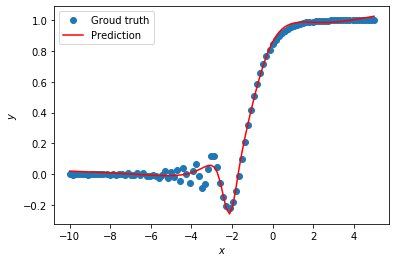

In [34]:
import matplotlib.pyplot as plt

def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), '-', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')


predict(net, x_validation, y_validation)

Фиксирование seed не гарантирует, что код будет одинаково выполняться на разных компьютерах. Но на одной и той же машине вы будете получать одинаковые результаты, перезапуская один и тот же скрипт.

Например, функция random.randint(start, end) отдает случайное целое число в диапазоне от start, end (включительно). Запуская скрипт, состоящий из вызова этой функции, вы будете получать разные ответы. 

В этом задании вам нужно подобрать seed, чтобы функция random.randint(0, 10) выдала число 5

PS: надо понимать, что фиксирование random seed не приведет к тому, что повторный вызов random.randint(0, 10) внутри того же скрипта снова даст 5. 

In [9]:
import random
random.seed(7)
print(random.randint(0, 10))

5
